> <h2>1st Version</h2>


In [ ]:
# ====================================================
# Neural Network based Encryption-Decryption (Alice, Bob, Eve)
# ====================================================

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

In [ ]:
# -----------------------
# Configurations
# -----------------------
MESSAGE_LEN = 16   # Length of plaintext message
KEY_LEN = 16       # Length of secret key
BATCH_SIZE = 512
EPOCHS = 50
LR = 0.001         # Learning rate

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# -----------------------
# Data Generator - Generates random 0/1 messages and 0/1 keys.
# -----------------------
def generate_batch(batch_size=BATCH_SIZE):
    messages = np.random.randint(0, 2, size=(batch_size, MESSAGE_LEN))
    keys = np.random.randint(0, 2, size=(batch_size, KEY_LEN))
    return torch.tensor(messages, dtype=torch.float32).to(device), \
           torch.tensor(keys, dtype=torch.float32).to(device)

In [ ]:
# -----------------------
# Simple Feedforward Networks for Alice, Bob, Eve
# -----------------------
class SimpleNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(SimpleNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, output_size),
            nn.Tanh()  # outputs between -1 and 1
        )
    def forward(self, x):
        return self.net(x)

Simple feedforward network: input → hidden → output.
- Tanh activation: outputs between -1 and 1.
- Alice: input = message + key → output = ciphertext.
- Bob: input = ciphertext + key → output = message.
- Eve: input = ciphertext → output = message guess.

In [ ]:
# Alice: (Message + Key) -> Ciphertext
Alice = SimpleNN(MESSAGE_LEN + KEY_LEN, MESSAGE_LEN).to(device)
# Bob: (Ciphertext + Key) -> Message
Bob   = SimpleNN(MESSAGE_LEN + KEY_LEN, MESSAGE_LEN).to(device)
# Eve: (Ciphertext only) -> Message
Eve   = SimpleNN(MESSAGE_LEN, MESSAGE_LEN).to(device)

In [ ]:
# -----------------------
# Loss Functions + Optimizers
# -----------------------
mse_loss = nn.MSELoss()

- Measures mean squared difference between predicted and target bits.
- Works better for continuous values than binary 0/1.

In [ ]:
opt_AliceBob = optim.Adam(list(Alice.parameters()) + list(Bob.parameters()), lr=LR)
opt_Eve      = optim.Adam(Eve.parameters(), lr=LR)

In [ ]:
bob_losses = []
eve_losses = []

In [ ]:
for epoch in range(EPOCHS):
    # ====== Train Eve ======
    messages, keys = generate_batch()

    alice_input = torch.cat([messages, keys], dim=1)
    ciphertext = Alice(alice_input).detach()  # stop gradients flowing into Alice

    eve_output = Eve(ciphertext)
    eve_loss = mse_loss(eve_output, messages)

    opt_Eve.zero_grad()
    eve_loss.backward()
    opt_Eve.step()

    # ====== Train Alice & Bob ======
    messages, keys = generate_batch()

    alice_input = torch.cat([messages, keys], dim=1)
    ciphertext = Alice(alice_input)

    bob_input = torch.cat([ciphertext, keys], dim=1)
    bob_output = Bob(bob_input)

    eve_output = Eve(ciphertext.detach())  # Eve is frozen here

    bob_loss = mse_loss(bob_output, messages)
    eve_loss_for_ab = mse_loss(eve_output, messages)

    alicebob_loss = bob_loss + (1 - eve_loss_for_ab)

    opt_AliceBob.zero_grad()
    alicebob_loss.backward()
    opt_AliceBob.step()

    # Save history
    bob_losses.append(bob_loss.item())
    eve_losses.append(eve_loss.item())

    if (epoch+1) % 5 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS} | Bob Loss: {bob_loss.item():.4f} | Eve Loss: {eve_loss.item():.4f}")

Epoch 5/50 | Bob Loss: 0.4664 | Eve Loss: 0.4974
Epoch 10/50 | Bob Loss: 0.4024 | Eve Loss: 0.4605
Epoch 15/50 | Bob Loss: 0.3369 | Eve Loss: 0.4015
Epoch 20/50 | Bob Loss: 0.2857 | Eve Loss: 0.3487
Epoch 25/50 | Bob Loss: 0.2613 | Eve Loss: 0.3081
Epoch 30/50 | Bob Loss: 0.2564 | Eve Loss: 0.2740
Epoch 35/50 | Bob Loss: 0.2553 | Eve Loss: 0.2615
Epoch 40/50 | Bob Loss: 0.2545 | Eve Loss: 0.2561
Epoch 45/50 | Bob Loss: 0.2520 | Eve Loss: 0.2514
Epoch 50/50 | Bob Loss: 0.2508 | Eve Loss: 0.2492


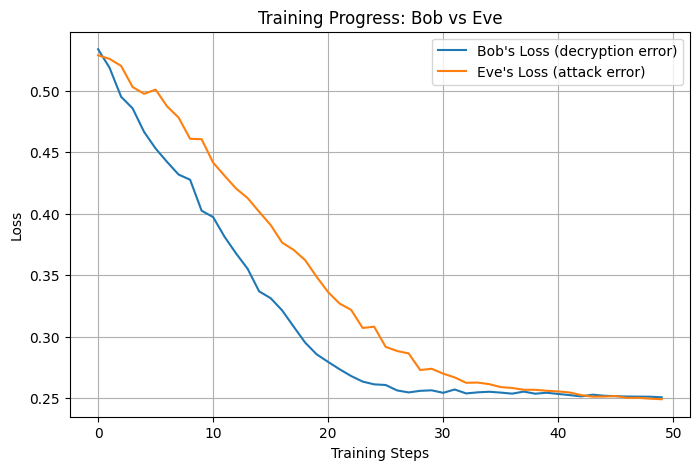

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(bob_losses, label="Bob's Loss (decryption error)")
plt.plot(eve_losses, label="Eve's Loss (attack error)")
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Training Progress: Bob vs Eve")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# -----------------------
# Testing
# -----------------------
test_messages, test_keys = generate_batch(5)
alice_input = torch.cat([test_messages, test_keys], dim=1)
ciphertext = Alice(alice_input)

bob_input = torch.cat([ciphertext, test_keys], dim=1)
bob_output = Bob(bob_input)

eve_output = Eve(ciphertext)

print("\n=== SAMPLE TEST ===")
for i in range(5):
    print(f"Message: {test_messages[i].cpu().detach().numpy().astype(int)}")
    print(f"Bob out: {np.round(bob_output[i].cpu().detach().numpy())}")
    print(f"Eve out: {np.round(eve_output[i].cpu().detach().numpy())}")
    print("-"*50)


=== SAMPLE TEST ===
Message: [1 0 1 0 1 0 0 1 1 0 1 0 1 1 1 0]
Bob out: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Eve out: [0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1.]
--------------------------------------------------
Message: [0 0 0 1 1 0 1 0 1 1 1 1 1 0 1 0]
Bob out: [0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1.]
Eve out: [1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1.]
--------------------------------------------------
Message: [0 0 0 1 0 0 1 1 0 1 1 0 1 1 1 0]
Bob out: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
Eve out: [1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1.]
--------------------------------------------------
Message: [0 1 0 1 1 0 0 1 1 1 1 0 0 1 0 0]
Bob out: [0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1.]
Eve out: [0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1.]
--------------------------------------------------
Message: [1 1 1 0 0 0 0 1 1 1 0 0 0 1 0 0]
Bob out: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
Eve out: [0. 0. 0. 0. 1. 1. 0

| Problem                   | Explanation                            | Effect                                   |
| ------------------------- | -------------------------------------- | ---------------------------------------- |
| **Tanh + 0/1 mismatch**   | Tanh outputs -1 to 1, messages are 0/1 | Rounding made Bob output all 0s          |
| **MSELoss for binary**    | MSE gives weak gradient for 0/1        | Network learned trivial solution         |
| **Small network**         | 32 neurons per layer                   | Couldn’t learn complex XOR-like patterns |
| **Raw output evaluation** | Tanh outputs not interpretable         | Hard to tell Bob/Eve accuracy            |


- Tanh + 0/1 targets mismatch → network outputs near 0, rounding made Bob always output 0s.

- MSELoss too weak for binary classification → training collapsed to trivial solutions.

- Graph reused twice → caused runtime error (“backward through graph a second time”).

- Evaluation → raw outputs looked like nonsense (all zeros), no clear accuracy.

- Small network → couldn’t learn stable patterns.

<hr>

> <h2>2nd Version</h2>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# -----------------------
# Configurations
# -----------------------
MESSAGE_LEN = 16   # length of plaintext
KEY_LEN = 16       # length of secret key
BATCH_SIZE = 512
EPOCHS = 200       # train longer for better convergence
LR = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# -----------------------
# Data Generator
# -----------------------
def generate_batch(batch_size=BATCH_SIZE):
    messages = np.random.randint(0, 2, size=(batch_size, MESSAGE_LEN))
    keys = np.random.randint(0, 2, size=(batch_size, KEY_LEN))
    return torch.tensor(messages, dtype=torch.float32).to(device), \
           torch.tensor(keys, dtype=torch.float32).to(device)

In [ ]:
# -----------------------
# Simple Feedforward Networks for Alice, Bob, Eve
# -----------------------
class SimpleNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(SimpleNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, output_size)   # logits (no activation)
        )
    def forward(self, x):
        return self.net(x)

- Increased network size: 64 neurons per layer → more capacity to learn encryption.
- Removed Tanh at output: Logits + BCE → no need for Tanh → avoids 0/1 mismatch.

In [ ]:
# Alice: (Message + Key) -> Ciphertext
Alice = SimpleNN(MESSAGE_LEN + KEY_LEN, MESSAGE_LEN).to(device)
# Bob: (Ciphertext + Key) -> Message
Bob   = SimpleNN(MESSAGE_LEN + KEY_LEN, MESSAGE_LEN).to(device)
# Eve: (Ciphertext only) -> Message
Eve   = SimpleNN(MESSAGE_LEN, MESSAGE_LEN).to(device)

In [ ]:
# -----------------------
# Loss Functions + Optimizers
# -----------------------
bce_loss = nn.BCEWithLogitsLoss()

opt_AliceBob = optim.Adam(list(Alice.parameters()) + list(Bob.parameters()), lr=LR)
opt_Eve      = optim.Adam(Eve.parameters(), lr=LR)

Switched to BCEWithLogitsLoss
- Works naturally for binary classification.
- Network outputs logits → sigmoid → compare with 0/1.

In [ ]:
# -----------------------
# Helper Functions
# -----------------------
def bit_accuracy(pred, true):
    return (pred == true).float().mean().item()

In [ ]:
# -----------------------
# Training Loop
# -----------------------
bob_losses, eve_losses = [], []
bob_accs, eve_accs = [], []

In [ ]:
for epoch in range(EPOCHS):
    # ====== Train Eve ======
    msgs, keys = generate_batch()
    with torch.no_grad():
        ciphertext = Alice(torch.cat([msgs, keys], dim=1))
    eve_logits = Eve(ciphertext.detach())
    loss_e = bce_loss(eve_logits, msgs)

    opt_Eve.zero_grad()
    loss_e.backward()
    opt_Eve.step()

    # ====== Train Alice & Bob ======
    msgs, keys = generate_batch()
    ciphertext = Alice(torch.cat([msgs, keys], dim=1))
    bob_logits = Bob(torch.cat([ciphertext, keys], dim=1))

    with torch.no_grad():
        eve_logits_ab = Eve(ciphertext.detach())

    loss_b = bce_loss(bob_logits, msgs)
    loss_e_ab = bce_loss(eve_logits_ab, msgs)

    # Alice & Bob want: Bob_loss small + Eve_loss large
    alicebob_loss = loss_b + (1.0 - loss_e_ab)

    opt_AliceBob.zero_grad()
    alicebob_loss.backward()
    opt_AliceBob.step()

    # ---- Evaluation on this batch ----
    with torch.no_grad():
        bob_pred = (torch.sigmoid(bob_logits) > 0.5).float()
        eve_pred = (torch.sigmoid(eve_logits) > 0.5).float()
        acc_bob = bit_accuracy(bob_pred, msgs)
        acc_eve = bit_accuracy(eve_pred, msgs)

    bob_losses.append(loss_b.item())
    eve_losses.append(loss_e.item())
    bob_accs.append(acc_bob)
    eve_accs.append(acc_eve)

    if (epoch+1) % 20 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS} | Bob Loss: {loss_b.item():.4f} | Eve Loss: {loss_e.item():.4f} | Bob Acc: {acc_bob:.3f} | Eve Acc: {acc_eve:.3f}")


Epoch 20/200 | Bob Loss: 0.6921 | Eve Loss: 0.6925 | Bob Acc: 0.525 | Eve Acc: 0.503
Epoch 40/200 | Bob Loss: 0.6735 | Eve Loss: 0.6826 | Bob Acc: 0.632 | Eve Acc: 0.498
Epoch 60/200 | Bob Loss: 0.6068 | Eve Loss: 0.6311 | Bob Acc: 0.674 | Eve Acc: 0.507
Epoch 80/200 | Bob Loss: 0.5190 | Eve Loss: 0.5503 | Bob Acc: 0.730 | Eve Acc: 0.490
Epoch 100/200 | Bob Loss: 0.4738 | Eve Loss: 0.5134 | Bob Acc: 0.759 | Eve Acc: 0.501
Epoch 120/200 | Bob Loss: 0.4525 | Eve Loss: 0.4770 | Bob Acc: 0.774 | Eve Acc: 0.507
Epoch 140/200 | Bob Loss: 0.4255 | Eve Loss: 0.4431 | Bob Acc: 0.788 | Eve Acc: 0.507
Epoch 160/200 | Bob Loss: 0.3956 | Eve Loss: 0.4182 | Bob Acc: 0.806 | Eve Acc: 0.493
Epoch 180/200 | Bob Loss: 0.3812 | Eve Loss: 0.3951 | Bob Acc: 0.810 | Eve Acc: 0.490
Epoch 200/200 | Bob Loss: 0.3648 | Eve Loss: 0.3892 | Bob Acc: 0.821 | Eve Acc: 0.500


- Training longer: 200 epochs → more stable convergence.
- Separated Eve and Alice/Bob losses properly: Avoids “graph reused” errors.

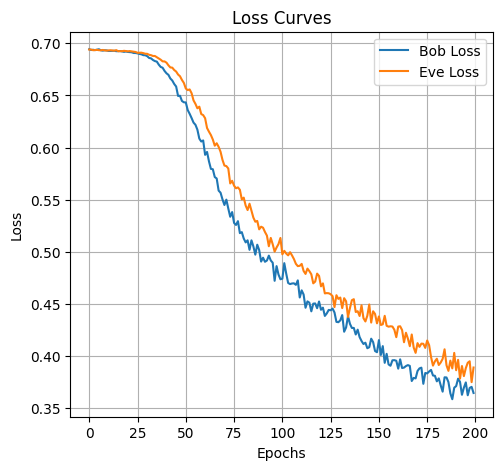

In [ ]:
# -----------------------
# Plot Loss and Accuracy Curves
# -----------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(bob_losses, label="Bob Loss")
plt.plot(eve_losses, label="Eve Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curves")
plt.legend()
plt.grid(True)

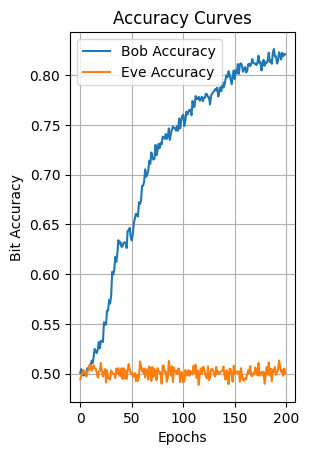

In [ ]:
plt.subplot(1,2,2)
plt.plot(bob_accs, label="Bob Accuracy")
plt.plot(eve_accs, label="Eve Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Bit Accuracy")
plt.title("Accuracy Curves")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# -----------------------
# Final Testing on Sample
# -----------------------
test_messages, test_keys = generate_batch(5)
with torch.no_grad():
    ct = Alice(torch.cat([test_messages, test_keys], dim=1))
    bob_logits = Bob(torch.cat([ct, test_keys], dim=1))
    eve_logits = Eve(ct)

    bob_pred = (torch.sigmoid(bob_logits) > 0.5).float()
    eve_pred = (torch.sigmoid(eve_logits) > 0.5).float()

print("\n=== SAMPLE TEST ===")
for i in range(5):
    print(f"Message: {test_messages[i].cpu().numpy().astype(int)}")
    print(f"Bob out: {bob_pred[i].cpu().numpy().astype(int)}")
    print(f"Eve out: {eve_pred[i].cpu().numpy().astype(int)}")
    print("-"*50)


=== SAMPLE TEST ===
Message: [0 1 1 0 0 1 1 0 1 1 0 0 0 0 0 1]
Bob out: [0 1 1 1 0 1 1 0 1 1 0 0 0 0 0 0]
Eve out: [0 1 1 0 1 1 1 0 1 1 0 0 0 0 1 0]
--------------------------------------------------
Message: [0 1 1 0 1 0 1 0 1 1 1 0 1 0 1 0]
Bob out: [0 1 1 1 1 1 1 0 1 1 1 0 1 0 0 0]
Eve out: [0 1 1 0 1 1 1 0 1 1 1 0 1 0 0 0]
--------------------------------------------------
Message: [0 1 1 1 0 1 1 1 0 0 0 1 0 0 0 0]
Bob out: [0 1 1 1 1 1 1 1 0 1 0 1 0 0 1 0]
Eve out: [0 1 1 1 0 1 1 1 0 1 0 1 0 0 1 0]
--------------------------------------------------
Message: [1 1 1 1 1 1 0 1 0 0 0 1 1 0 0 1]
Bob out: [0 1 1 1 1 1 0 1 0 0 0 1 1 0 0 1]
Eve out: [0 1 1 0 1 1 0 1 0 0 0 1 1 0 0 1]
--------------------------------------------------
Message: [0 1 0 1 1 0 0 1 1 1 1 0 0 0 1 1]
Bob out: [1 1 0 1 1 0 0 1 1 1 1 0 0 0 1 0]
Eve out: [1 1 0 1 1 0 0 1 1 1 1 0 0 0 1 0]
--------------------------------------------------


Better evaluation
- Use torch.sigmoid() → threshold at 0.5 → get actual bits.
- Track bit accuracy over epochs.

**Issues**
- The networks are simple feedforward networks; they are not classical AES-style encryption.
- Training is on random bits, and EPOCHS might not be enough for perfect convergence.
- Neural networks output logits → sigmoid → thresholding at 0.5 produces the final bits. Some outputs will naturally misclassify.

**Key takeaways**

- Bob’s accuracy is higher than Eve’s, which means the network learned to “encrypt” in a way that is usable only with the key.
- Eve’s output is partially correct by chance, but she cannot reliably recover messages.
- From the plot:
  - Bob’s accuracy increasing toward 1 (ideal is 1.0).
  - Eve’s accuracy hovering around 0.5 (random guessing), which is good.

<hr>

> <h2> 3rd Version

In [ ]:
# -----------------------
# Configurations
# -----------------------
MESSAGE_LEN = 16
KEY_LEN = 16
BATCH_SIZE = 512
EPOCHS = 300
LR = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# -----------------------
# Data Generator
# -----------------------
def generate_batch(batch_size=BATCH_SIZE):
    messages = np.random.randint(0, 2, size=(batch_size, MESSAGE_LEN))
    keys = np.random.randint(0, 2, size=(batch_size, KEY_LEN))
    return torch.tensor(messages, dtype=torch.float32).to(device), \
           torch.tensor(keys, dtype=torch.float32).to(device)

In [ ]:
# -----------------------
# Feedforward Networks for Alice, Bob, Eve
# -----------------------
class SimpleNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(SimpleNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_size)   # logits
        )
    def forward(self, x):
        return self.net(x)

In [ ]:
Alice = SimpleNN(MESSAGE_LEN + KEY_LEN, MESSAGE_LEN).to(device)
Bob   = SimpleNN(MESSAGE_LEN + KEY_LEN, MESSAGE_LEN).to(device)
Eve   = SimpleNN(MESSAGE_LEN, MESSAGE_LEN).to(device)

In [ ]:
# -----------------------
# Loss + Optimizers
# -----------------------
bce_loss = nn.BCEWithLogitsLoss()
opt_AliceBob = optim.Adam(list(Alice.parameters()) + list(Bob.parameters()), lr=LR)
opt_Eve = optim.Adam(Eve.parameters(), lr=LR)

In [ ]:
# -----------------------
# Accuracy Helper
# -----------------------
def bit_accuracy(pred, true):
    return (pred == true).float().mean().item()

In [ ]:
# -----------------------
# Training Loop
# -----------------------
bob_losses, eve_losses = [], []
bob_accs, eve_accs = [], []

In [ ]:
for epoch in range(EPOCHS):
    # ===== Train Eve =====
    msgs, keys = generate_batch()
    with torch.no_grad():
        ciphertext = Alice(torch.cat([msgs, keys], dim=1))
    eve_logits = Eve(ciphertext)
    loss_e = bce_loss(eve_logits, msgs)

    opt_Eve.zero_grad()
    loss_e.backward()
    opt_Eve.step()

    # ===== Train Alice & Bob =====
    msgs, keys = generate_batch()
    ciphertext = Alice(torch.cat([msgs, keys], dim=1))
    bob_logits = Bob(torch.cat([ciphertext, keys], dim=1))

    with torch.no_grad():
        eve_logits_ab = Eve(ciphertext)

    loss_b = bce_loss(bob_logits, msgs)
    loss_e_ab = bce_loss(eve_logits_ab, msgs)

    # Alice & Bob loss: Bob small + Eve large
    alicebob_loss = loss_b + (1.0 - loss_e_ab)

    opt_AliceBob.zero_grad()
    alicebob_loss.backward()
    opt_AliceBob.step()

    # ---- Evaluation ----
    with torch.no_grad():
        bob_pred = (torch.sigmoid(bob_logits) > 0.5).float()
        eve_pred = (torch.sigmoid(eve_logits) > 0.5).float()
        acc_bob = bit_accuracy(bob_pred, msgs)
        acc_eve = bit_accuracy(eve_pred, msgs)

    bob_losses.append(loss_b.item())
    eve_losses.append(loss_e.item())
    bob_accs.append(acc_bob)
    eve_accs.append(acc_eve)

    if (epoch+1) % 50 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS} | Bob Loss: {loss_b.item():.4f} | Eve Loss: {loss_e.item():.4f} | Bob Acc: {acc_bob:.3f} | Eve Acc: {acc_eve:.3f}")

Epoch 50/300 | Bob Loss: 0.4969 | Eve Loss: 0.5071 | Bob Acc: 0.754 | Eve Acc: 0.497
Epoch 100/300 | Bob Loss: 0.3216 | Eve Loss: 0.3220 | Bob Acc: 0.853 | Eve Acc: 0.493
Epoch 150/300 | Bob Loss: 0.2355 | Eve Loss: 0.2337 | Bob Acc: 0.894 | Eve Acc: 0.493
Epoch 200/300 | Bob Loss: 0.1454 | Eve Loss: 0.1650 | Bob Acc: 0.940 | Eve Acc: 0.501
Epoch 250/300 | Bob Loss: 0.1207 | Eve Loss: 0.1272 | Bob Acc: 0.948 | Eve Acc: 0.509
Epoch 300/300 | Bob Loss: 0.0977 | Eve Loss: 0.1003 | Bob Acc: 0.954 | Eve Acc: 0.505


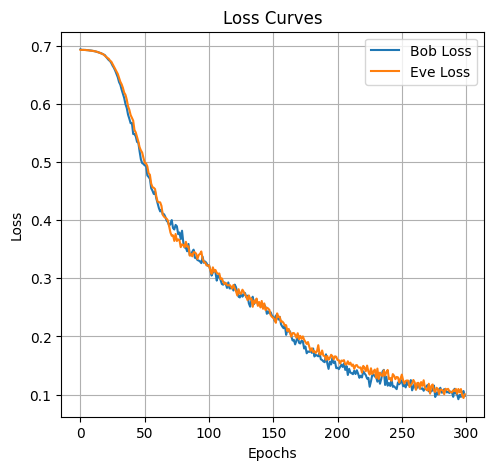

In [ ]:
# -----------------------
# Plot Curves
# -----------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(bob_losses, label="Bob Loss")
plt.plot(eve_losses, label="Eve Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curves")
plt.legend()
plt.grid(True)

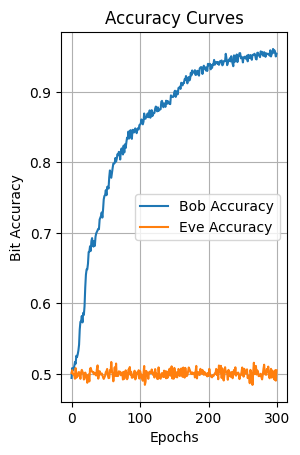

In [ ]:
plt.subplot(1,2,2)
plt.plot(bob_accs, label="Bob Accuracy")
plt.plot(eve_accs, label="Eve Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Bit Accuracy")
plt.title("Accuracy Curves")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# -----------------------
# Sample Test
# -----------------------
test_messages, test_keys = generate_batch(5)
with torch.no_grad():
    ct = Alice(torch.cat([test_messages, test_keys], dim=1))
    bob_logits = Bob(torch.cat([ct, test_keys], dim=1))
    eve_logits = Eve(ct)

    bob_pred = (torch.sigmoid(bob_logits) > 0.5).float()
    eve_pred = (torch.sigmoid(eve_logits) > 0.5).float()

print("\n=== SAMPLE TEST ===")
for i in range(5):
    print(f"Message      : {test_messages[i].cpu().numpy().astype(int)}")
    print(f"Ciphertext   : {ct[i].cpu().numpy().round(3)}")
    print(f"Bob Decrypted: {bob_pred[i].cpu().numpy().astype(int)}")
    print(f"Eve Guess    : {eve_pred[i].cpu().numpy().astype(int)}")
    print("-"*60)


=== SAMPLE TEST ===
Message      : [1 1 1 0 1 1 1 1 1 0 1 0 1 0 0 0]
Ciphertext   : [-10.346  -5.819  -2.426   2.974   3.848  -2.256  -5.547  10.534  -7.368
  10.094  -9.802  -2.032   4.594  -6.647   5.881   1.924]
Bob Decrypted: [1 1 1 0 1 1 1 1 1 0 1 0 1 1 0 1]
Eve Guess    : [1 1 1 0 1 1 1 1 1 0 1 0 1 1 0 0]
------------------------------------------------------------
Message      : [1 0 0 1 1 1 1 0 0 1 0 1 0 1 1 1]
Ciphertext   : [-7.512 -5.086  2.129  6.161  6.189 -7.887 -5.118  8.035 -8.258  7.655
 -8.104 -6.327  0.663 -4.265  4.285 -3.003]
Bob Decrypted: [1 0 0 1 1 1 1 0 0 1 0 1 0 1 1 1]
Eve Guess    : [1 0 0 1 1 1 1 0 0 1 0 1 0 1 1 1]
------------------------------------------------------------
Message      : [1 0 1 1 1 1 0 0 1 1 1 0 0 1 0 1]
Ciphertext   : [-8.937 -7.584 -0.238  8.838  7.998 -2.4   -6.437  8.955 -8.638  6.493
 -6.097 -1.753  2.653 -1.815  3.368  0.687]
Bob Decrypted: [1 0 1 1 1 1 0 0 1 1 1 0 0 0 0 1]
Eve Guess    : [1 0 1 1 1 1 0 0 1 1 1 0 0 1 0 1]
----------

**Why decimals instead of 0/1?**
- Neural networks output continuous values, even if your messages are binary.
- Bob (and Eve) learn to interpret these continuous outputs to reconstruct the bits.
- The network never explicitly forces Alice to produce 0/1 bits — it’s free to use any continuous representation as “ciphertext”.

**Possible reasons for eve's almost success:**

- Your network might not be fully converged: 300 epochs may still allow Eve to partially “learn patterns”.
- The task is only 16-bit messages → a neural network can memorize or approximate patterns, especially with small messages.
- BCEWithLogitsLoss alone does not guarantee cryptographic security — it only encourages Eve to make errors, but neural nets are approximators, not provably secure cryptography.

⚠️ Important: Neural cryptography is not truly cryptographically secure like AES/RSA. It’s an experiment in adversarial learning. Eve sometimes succeeds, especially with small message lengths.

**Should ciphertext be binary?**
- In classical encryption, yes — ciphertext is usually 0/1 bits.
- In neural cryptography, it is okay for ciphertext to be continuous.
- Why? Because the network learns a mapping such that Bob + key → message.

<hr>

> <h2> 4th Version

In [ ]:
# -----------------------
# Configurations
# -----------------------
MESSAGE_LEN = 16
KEY_LEN = 16
BATCH_SIZE = 512
EPOCHS = 500
LR = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# -----------------------
# Data Generator
# -----------------------
def generate_batch(batch_size=BATCH_SIZE):
    messages = np.random.randint(0, 2, size=(batch_size, MESSAGE_LEN))
    keys = np.random.randint(0, 2, size=(batch_size, KEY_LEN))
    return torch.tensor(messages, dtype=torch.float32).to(device), \
           torch.tensor(keys, dtype=torch.float32).to(device)

In [ ]:
# -----------------------
# Feedforward Networks for Alice, Bob, Eve
# -----------------------
class SimpleNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(SimpleNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, output_size)   # logits
        )
    def forward(self, x):
        return self.net(x)

In [ ]:
Alice = SimpleNN(MESSAGE_LEN + KEY_LEN, MESSAGE_LEN).to(device)
Bob   = SimpleNN(MESSAGE_LEN + KEY_LEN, MESSAGE_LEN).to(device)
Eve   = SimpleNN(MESSAGE_LEN, MESSAGE_LEN).to(device)

In [ ]:
# -----------------------
# Loss + Optimizers
# -----------------------
bce_loss = nn.BCEWithLogitsLoss()
opt_AliceBob = optim.Adam(list(Alice.parameters()) + list(Bob.parameters()), lr=LR)
opt_Eve = optim.Adam(Eve.parameters(), lr=LR)

In [ ]:
# -----------------------
# Accuracy Helper
# -----------------------
def bit_accuracy(pred, true):
    return (pred == true).float().mean().item()

In [ ]:
# -----------------------
# Training Loop
# -----------------------
bob_losses, eve_losses = [], []
bob_accs, eve_accs = [], []

for epoch in range(EPOCHS):
    # ===== Train Eve =====
    msgs, keys = generate_batch()
    with torch.no_grad():
        ciphertext = Alice(torch.cat([msgs, keys], dim=1))
        # optional: add tiny noise to confuse Eve
        ciphertext_noisy = ciphertext + 0.01 * torch.randn_like(ciphertext)
    eve_logits = Eve(ciphertext_noisy)
    loss_e = bce_loss(eve_logits, msgs)

    opt_Eve.zero_grad()
    loss_e.backward()
    opt_Eve.step()

    # ===== Train Alice & Bob =====
    msgs, keys = generate_batch()
    ciphertext = Alice(torch.cat([msgs, keys], dim=1))
    bob_logits = Bob(torch.cat([ciphertext, keys], dim=1))

    with torch.no_grad():
        eve_logits_ab = Eve(ciphertext)

    loss_b = bce_loss(bob_logits, msgs)
    loss_e_ab = bce_loss(eve_logits_ab, msgs)

    # Alice & Bob loss: Bob small + Eve large (strong adversarial weight)
    alicebob_loss = loss_b + 2.0 * (1.0 - loss_e_ab)

    opt_AliceBob.zero_grad()
    alicebob_loss.backward()
    opt_AliceBob.step()

    # ---- Evaluation ----
    with torch.no_grad():
        bob_pred = (torch.sigmoid(bob_logits) > 0.5).float()
        eve_pred = (torch.sigmoid(eve_logits) > 0.5).float()
        acc_bob = bit_accuracy(bob_pred, msgs)
        acc_eve = bit_accuracy(eve_pred, msgs)

    bob_losses.append(loss_b.item())
    eve_losses.append(loss_e.item())
    bob_accs.append(acc_bob)
    eve_accs.append(acc_eve)

    if (epoch+1) % 50 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS} | Bob Loss: {loss_b.item():.4f} | Eve Loss: {loss_e.item():.4f} | Bob Acc: {acc_bob:.3f} | Eve Acc: {acc_eve:.3f}")

Epoch 50/500 | Bob Loss: 0.3497 | Eve Loss: 0.3466 | Bob Acc: 0.838 | Eve Acc: 0.495
Epoch 100/500 | Bob Loss: 0.1401 | Eve Loss: 0.1233 | Bob Acc: 0.948 | Eve Acc: 0.500
Epoch 150/500 | Bob Loss: 0.0352 | Eve Loss: 0.0314 | Bob Acc: 0.991 | Eve Acc: 0.503
Epoch 200/500 | Bob Loss: 0.0157 | Eve Loss: 0.0102 | Bob Acc: 0.997 | Eve Acc: 0.502
Epoch 250/500 | Bob Loss: 0.0052 | Eve Loss: 0.0037 | Bob Acc: 0.999 | Eve Acc: 0.505
Epoch 300/500 | Bob Loss: 0.0021 | Eve Loss: 0.0052 | Bob Acc: 1.000 | Eve Acc: 0.506
Epoch 350/500 | Bob Loss: 0.0010 | Eve Loss: 0.0009 | Bob Acc: 1.000 | Eve Acc: 0.500
Epoch 400/500 | Bob Loss: 0.0009 | Eve Loss: 0.0020 | Bob Acc: 1.000 | Eve Acc: 0.506
Epoch 450/500 | Bob Loss: 0.0006 | Eve Loss: 0.0007 | Bob Acc: 1.000 | Eve Acc: 0.492
Epoch 500/500 | Bob Loss: 0.0010 | Eve Loss: 0.0012 | Bob Acc: 1.000 | Eve Acc: 0.504


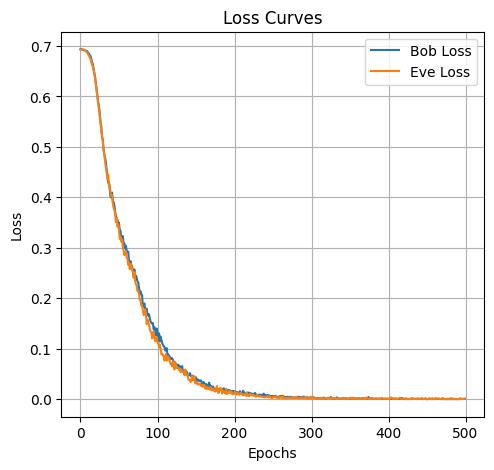

In [ ]:
# -----------------------
# Plot Curves
# -----------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(bob_losses, label="Bob Loss")
plt.plot(eve_losses, label="Eve Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curves")
plt.legend()
plt.grid(True)

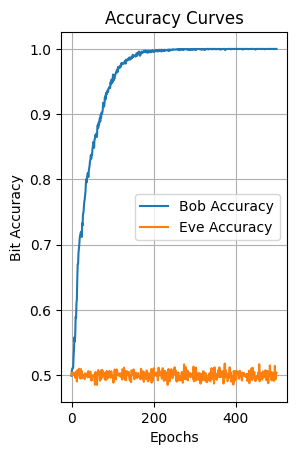

In [ ]:
plt.subplot(1,2,2)
plt.plot(bob_accs, label="Bob Accuracy")
plt.plot(eve_accs, label="Eve Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Bit Accuracy")
plt.title("Accuracy Curves")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# -----------------------
# Sample Test
# -----------------------
test_messages, test_keys = generate_batch(5)
with torch.no_grad():
    ct = Alice(torch.cat([test_messages, test_keys], dim=1))
    bob_logits = Bob(torch.cat([ct, test_keys], dim=1))
    eve_logits = Eve(ct)

    bob_pred = (torch.sigmoid(bob_logits) > 0.5).float()
    eve_pred = (torch.sigmoid(eve_logits) > 0.5).float()

print("\n=== SAMPLE TEST ===")
for i in range(5):
    print(f"Message      : {test_messages[i].cpu().numpy().astype(int)}")
    print(f"Ciphertext   : {ct[i].cpu().numpy().round(3)}")
    print(f"Bob Decrypted: {bob_pred[i].cpu().numpy().astype(int)}")
    print(f"Eve Guess    : {eve_pred[i].cpu().numpy().astype(int)}")
    print("-"*60)


=== SAMPLE TEST ===
Message      : [1 0 1 0 0 0 1 1 0 0 1 0 0 1 1 0]
Ciphertext   : [ -0.802  -8.034  -2.117   6.632 -11.049   4.902   6.597  14.764  -8.075
  -7.986  -9.747 -10.006  11.269  -8.555  -3.827  -3.333]
Bob Decrypted: [1 0 1 0 0 0 1 1 0 0 1 0 0 1 1 0]
Eve Guess    : [1 0 1 0 0 0 1 1 0 0 1 0 0 1 1 0]
------------------------------------------------------------
Message      : [1 1 0 0 0 0 0 0 1 0 1 1 1 1 1 0]
Ciphertext   : [  2.439  -6.361   2.149   8.382  -7.006   4.275   3.655   0.555 -11.862
  -7.007  -5.799  -6.475   5.008  -4.08   -4.96    0.713]
Bob Decrypted: [1 1 0 0 0 0 0 0 1 0 1 1 1 1 1 0]
Eve Guess    : [1 1 0 0 0 0 0 0 1 0 1 1 1 1 1 0]
------------------------------------------------------------
Message      : [1 0 0 0 1 0 1 0 0 1 1 1 1 1 0 1]
Ciphertext   : [-0.291 -9.272  6.495  9.007 -6.05  -2.825  6.837  5.707 -4.942 -2.262
 -8.835 -8.671  5.702 -3.699 -5.251 -3.743]
Bob Decrypted: [1 0 0 0 1 0 1 0 0 1 1 1 1 1 0 1]
Eve Guess    : [1 0 0 0 1 0 1 0 0 1 1 1 1 1

This means Eve has “learned” the mapping from ciphertext to message. Why?
- Message length is tiny (16 bits) → a neural network can easily memorize or approximate the mapping.
- Alice’s network is deterministic → given the same message + key, the ciphertext is always the same. Eve can pick up the pattern.
- Training setup → Eve is trained alongside Alice/Bob, so she’s effectively learning the “weakest link.”

⚠️ Important: Neural networks in this setup are not cryptographically secure. There is no mathematically guaranteed security like AES or RSA. The more Eve sees, the better she can guess.


**Does this mean communication is insecure?**

Yes, in this experiment:
- Bob always decrypts perfectly (good).
- Eve can also decrypt perfectly (bad).

So the communication is NOT secure against an adversary who knows the network architecture and can train like Eve.



**Neural cryptography is more of a “proof of concept”:**
- With tiny message sizes, neural networks cannot hide the message well.
- To make it more “secure”:
    - Use longer messages (e.g., 128+ bits).
    - Use larger keys.
    - Introduce randomness/noise in Alice’s encryption.
    - Train with strong adversarial weighting for Eve.
- Even then, it’s never provably secure. Neural nets approximate encryption; they don’t guarantee secrecy

<hr>

> <h2> 5th Version

In [ ]:
# -----------------------
# Configurations
# -----------------------
MESSAGE_LEN = 128   # longer plaintext
KEY_LEN = 128       # longer key
BATCH_SIZE = 512
EPOCHS = 600
LR = 0.001
NOISE_SCALE = 0.1   # amount of random noise in Alice's ciphertext


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# -----------------------
# Data Generator
# -----------------------
def generate_batch(batch_size=BATCH_SIZE):
    messages = np.random.randint(0, 2, size=(batch_size, MESSAGE_LEN))
    keys = np.random.randint(0, 2, size=(batch_size, KEY_LEN))
    return torch.tensor(messages, dtype=torch.float32).to(device), \
           torch.tensor(keys, dtype=torch.float32).to(device)

In [ ]:
# -----------------------
# Neural Networks
# -----------------------
class SimpleNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(SimpleNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, output_size)   # continuous output
        )
    def forward(self, x):
        return self.net(x)

Alice = SimpleNN(MESSAGE_LEN + KEY_LEN, MESSAGE_LEN).to(device)
Bob   = SimpleNN(MESSAGE_LEN + KEY_LEN, MESSAGE_LEN).to(device)
Eve   = SimpleNN(MESSAGE_LEN, MESSAGE_LEN).to(device)

In [ ]:
# -----------------------
# Loss and Optimizers
# -----------------------
bce_loss = nn.BCEWithLogitsLoss()
opt_AliceBob = optim.Adam(list(Alice.parameters()) + list(Bob.parameters()), lr=LR)
opt_Eve = optim.Adam(Eve.parameters(), lr=LR)

In [ ]:
# -----------------------
# Helper
# -----------------------
def bit_accuracy(pred, true):
    return (pred == true).float().mean().item()

In [ ]:
# -----------------------
# Training Loop
# -----------------------
bob_losses, eve_losses = [], []
bob_accs, eve_accs = [], []

for epoch in range(EPOCHS):
    # ===== Train Eve =====
    msgs, keys = generate_batch()
    with torch.no_grad():
        ciphertext = Alice(torch.cat([msgs, keys], dim=1))
        ciphertext_noisy = ciphertext + NOISE_SCALE * torch.randn_like(ciphertext)
    eve_logits = Eve(ciphertext_noisy)
    loss_e = bce_loss(eve_logits, msgs)

    opt_Eve.zero_grad()
    loss_e.backward()
    opt_Eve.step()

    # ===== Train Alice & Bob =====
    msgs, keys = generate_batch()
    ciphertext = Alice(torch.cat([msgs, keys], dim=1))
    bob_logits = Bob(torch.cat([ciphertext, keys], dim=1))

    with torch.no_grad():
        eve_logits_ab = Eve(ciphertext)

    loss_b = bce_loss(bob_logits, msgs)
    loss_e_ab = bce_loss(eve_logits_ab, msgs)

    # Alice & Bob want Bob small + Eve large (strong adversarial weight)
    alicebob_loss = loss_b + 3.0 * (1.0 - loss_e_ab)  # stronger weighting

    opt_AliceBob.zero_grad()
    alicebob_loss.backward()
    opt_AliceBob.step()

    # ---- Evaluation ----
    with torch.no_grad():
        bob_pred = (torch.sigmoid(bob_logits) > 0.5).float()
        eve_pred = (torch.sigmoid(eve_logits) > 0.5).float()
        acc_bob = bit_accuracy(bob_pred, msgs)
        acc_eve = bit_accuracy(eve_pred, msgs)

    bob_losses.append(loss_b.item())
    eve_losses.append(loss_e.item())
    bob_accs.append(acc_bob)
    eve_accs.append(acc_eve)

    if (epoch+1) % 50 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS} | Bob Loss: {loss_b.item():.4f} | Eve Loss: {loss_e.item():.4f} | Bob Acc: {acc_bob:.3f} | Eve Acc: {acc_eve:.3f}")

Epoch 50/600 | Bob Loss: 0.6507 | Eve Loss: 0.6473 | Bob Acc: 0.622 | Eve Acc: 0.500
Epoch 100/600 | Bob Loss: 0.5946 | Eve Loss: 0.5900 | Bob Acc: 0.679 | Eve Acc: 0.500
Epoch 150/600 | Bob Loss: 0.5584 | Eve Loss: 0.5562 | Bob Acc: 0.711 | Eve Acc: 0.500
Epoch 200/600 | Bob Loss: 0.5260 | Eve Loss: 0.5217 | Bob Acc: 0.736 | Eve Acc: 0.499
Epoch 250/600 | Bob Loss: 0.4999 | Eve Loss: 0.5014 | Bob Acc: 0.755 | Eve Acc: 0.502
Epoch 300/600 | Bob Loss: 0.4731 | Eve Loss: 0.4728 | Bob Acc: 0.772 | Eve Acc: 0.500
Epoch 350/600 | Bob Loss: 0.4481 | Eve Loss: 0.4438 | Bob Acc: 0.787 | Eve Acc: 0.497
Epoch 400/600 | Bob Loss: 0.4367 | Eve Loss: 0.4287 | Bob Acc: 0.792 | Eve Acc: 0.498
Epoch 450/600 | Bob Loss: 0.4089 | Eve Loss: 0.4026 | Bob Acc: 0.808 | Eve Acc: 0.497
Epoch 500/600 | Bob Loss: 0.3950 | Eve Loss: 0.3944 | Bob Acc: 0.817 | Eve Acc: 0.503
Epoch 550/600 | Bob Loss: 0.3722 | Eve Loss: 0.3757 | Bob Acc: 0.828 | Eve Acc: 0.498
Epoch 600/600 | Bob Loss: 0.3557 | Eve Loss: 0.3606 | B

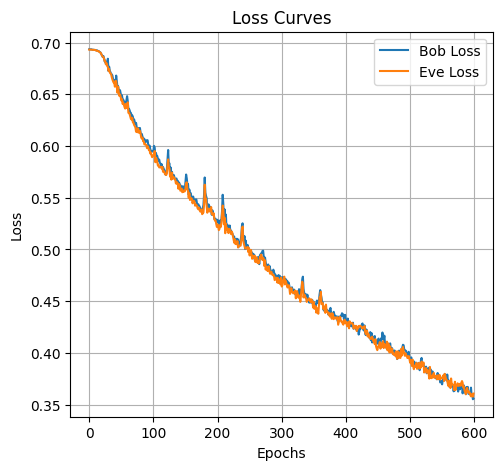

In [ ]:
# -----------------------
# Plot Curves
# -----------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(bob_losses, label="Bob Loss")
plt.plot(eve_losses, label="Eve Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curves")
plt.legend()
plt.grid(True)

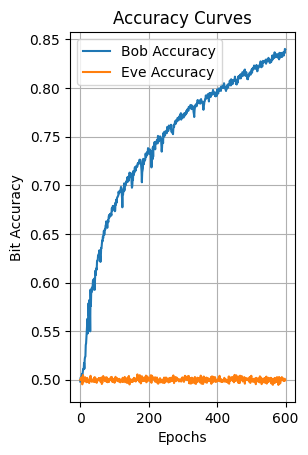

In [ ]:
plt.subplot(1,2,2)
plt.plot(bob_accs, label="Bob Accuracy")
plt.plot(eve_accs, label="Eve Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Bit Accuracy")
plt.title("Accuracy Curves")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# -----------------------
# Sample Test
# -----------------------
test_messages, test_keys = generate_batch(5)
with torch.no_grad():
    ct = Alice(torch.cat([test_messages, test_keys], dim=1))
    bob_logits = Bob(torch.cat([ct, test_keys], dim=1))
    eve_logits = Eve(ct)

    bob_pred = (torch.sigmoid(bob_logits) > 0.5).float()
    eve_pred = (torch.sigmoid(eve_logits) > 0.5).float()

print("\n=== SAMPLE TEST ===")
for i in range(5):
    print(f"Message      : {test_messages[i].cpu().numpy().astype(int)}")
    print(f"Ciphertext   : {ct[i].cpu().numpy().round(3)}")
    print(f"Bob Decrypted: {bob_pred[i].cpu().numpy().astype(int)}")
    print(f"Eve Guess    : {eve_pred[i].cpu().numpy().astype(int)}")
    print("-"*70)


=== SAMPLE TEST ===
Message      : [0 1 0 1 0 0 1 0 1 1 1 0 1 0 1 1 0 1 0 0 0 0 0 1 1 1 0 0 1 0 0 1 1 1 0 0 0
 1 1 0 0 1 1 0 1 1 0 0 1 0 0 0 1 0 1 1 1 0 0 1 1 1 0 1 0 0 1 0 0 0 1 1 0 1
 0 1 0 1 1 0 1 0 0 0 1 1 1 0 0 1 0 1 0 0 1 0 0 0 0 1 1 1 0 1 0 0 0 0 0 1 0
 0 0 1 1 1 0 0 0 0 1 1 1 0 0 1 1 1]
Ciphertext   : [-1.09   2.568  3.296 -1.351 -0.634 -0.325  1.227  0.835  2.49   0.148
 -0.377  1.729 -0.744 -0.812 -1.774  1.4   -2.852  0.932 -1.044 -0.604
  4.349  0.546  0.388 -1.141 -3.089  1.606 -0.205 -0.262 -0.114  2.655
  2.281 -0.273  0.637 -1.283 -1.28   1.304 -0.365  0.252  0.546  1.564
 -0.911 -0.172  2.082 -1.982  2.154 -1.312 -1.13   0.402 -5.302 -0.457
  2.508  1.837 -0.022 -0.912 -0.739 -3.014 -2.746  0.901  0.096  0.135
 -0.096  0.078  0.455  0.971  0.089  0.135 -5.571  2.319  0.394  2.453
  1.609  0.665 -0.345  0.516  6.329 -0.275 -1.904  0.744  3.152 -0.878
 -2.005 -0.62  -1.721 -3.047 -0.509  0.988 -1.09   1.152 -0.96  -1.484
 -1.409 -1.233  0.862 -0.887 -1.865  0.454  1.723